## Trading Options with the Black-Scholes Implied Volatility Surface

**As an exotics trader, you get a request on IB:**

 ```
 Got a D/O Call on AAPL for you.
 Strike 220, Barrier 190.
 17 Jan 26 expiry, zero rebate.
 Size 100k shares.
 Send me your best two-way for a few mins.
 ```

How do you go about giving a quote in this capacity?

We need to understand the...
- Black-Scholes Model
- Implied Volatility Surface
- Calibration Problem with Black-Scholes
- Solutions to this Black-Scholes Calibration Problem

---

### The Black-Scholes Model

Solving the Black-Scholes Equation Yields:

$$C = S_t \Phi(d_1) - Ke^{-rt} \Phi(d_2)$$

$$\Phi(x) = \int_{-\infty}^x \frac{1}{\sqrt{2\pi}}e^{\frac{-s^2}{2}}ds$$

$$d_1 = \frac{ln(\frac{S_t}{K})+(r+\frac{\sigma^2}{2})t}{\sigma \sqrt{t}}$$

$$d_2 = d_1 - \sigma \sqrt{t}$$


Mathematically, the Black-Scholes formula is a functional, a map from $\mathbb{R}^5 \rightarrow \mathbb{R}$:

$BS: (S, K, r, \sigma, T) \mapsto C$

Where:
- $S \in \mathbb{R}^+ $ (spot price)
- $K \in \mathbb{R}^+$ (strike price) 
- $r \in \mathbb{R}$ (risk-free rate)
- $\sigma \in \mathbb{R}^+$ (volatility)
- $T \in \mathbb{R}^+$ (time to expiry)
$\mapsto C \in \mathbb{R}^+$ (call option price)


In [2]:
import numpy as np
from scipy.stats import norm

def black_scholes_call(S, K, r, sigma, T):
    """
    Calculate Black-Scholes price for a European call option.
    
    Parameters:
    S (float): Current stock price
    K (float): Strike price
    r (float): Risk-free interest rate
    sigma (float): Volatility
    T (float): Time to expiration (in years)
    
    Returns:
    float: Call option price
    """
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    call = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return call

---

### Example: Pricing an Option with the Black-Scholes Model

It seems odd, we already have all of the inputs (except volatility) to the Black-Scholes model.

In fact, we also have the option's price - this is dictated by supply and demand!

In [3]:
S = 100 # Spot is given by the market/contract
K = 100 # Strike is given by the market/contract
r = 0.05 # Risk-free rate is given by the market/contract
T = 1 # Time to maturity is given by the market/contract

# Thanks to supply and demand, the market price of the call option is given by the market/contract
C = 9.36 # Call option price is given by the market/contract

# Volatility is not observable!  We can proxy for it using a variety of measures but it isn't directly available.
sigma = 0.2 # Volatility is NOT given by the market/contract!

print("The Black-Scholes call option price is: $", np.round(black_scholes_call(S, K, r, sigma, T), 2))

The Black-Scholes call option price is: $ 10.45


---

### *Guessing* Implied Volatilities

We can *guess* the IV required to produce the market price of the option under the given parameter set by the market/contract. 

In [ ]:
S = 100 # Spot is given by the market/contract
K = 90 # Strike is given by the market/contract
r = 0.05 # Risk-free rate is given by the market/contract
T = 1 # Time to maturity is given by the market/contract

# Thanks to supply and demand, the market price of the call option is given by the market/contract
C = 17.50 # Call option price is given by the market/contract

# Volatility is not observable!  We can proxy for it using a variety of measures but it isn't directly available.
sigma = 0.25 # Volatility is NOT given by the market/contract!

print("The Black-Scholes call option price is: $", np.round(black_scholes_call(S, K, r, sigma, T), 2))

The Black-Scholes call option price is: $ 12.34


This is impractical, instead we setup an optimization problem from traditional calculus:

$$\sigma^* = min_{\sigma} (C_{mkt} - C_{BS})^2$$

where $\sigma^*$ is the *Black-Scholes implied volatility*!

---

### Black-Scholes Implied Volatility

Mathematically the Black-Scholes functional requires 5 inputs:
- $S \in \mathbb{R}^+ $ (spot price)
- $K \in \mathbb{R}^+$ (strike price) 
- $r \in \mathbb{R}$ (risk-free rate)
- $\sigma \in \mathbb{R}^+$ (volatility)
- $T \in \mathbb{R}^+$ (time to expiry)
$\mapsto C \in \mathbb{R}^+$ (call option price)

But really, we only get to *freely* choose one: volatility.  The market or our contract decides the other parameters!

Essentially, we can look at this as a function only of volatility:

$BS(\sigma) = C \implies BS^{-1}(C) = \sigma$

which will allow us to find the volatility for our Black-Scholes framework - this is *implied volatility*!

To find this value we can setup and solve this minimization problem:

$$\sigma^* = min_{\sigma} (C_{mkt} - C_{BS})^2$$

when distance is near zero between the market option price and the Black-Scholes price we've found the implied volatility (within a reasonable level of precision)!

In [19]:
from scipy.optimize import newton

def implied_volatility(C, S, K, r, T, sigma_init=0.2):
    """
    Calculate implied volatility using Newton-Raphson method.
    
    Parameters:
    C (float): Market price of call option
    S (float): Current stock price
    K (float): Strike price
    r (float): Risk-free interest rate
    T (float): Time to expiration (in years)
    sigma_init (float): Initial volatility guess
    
    Returns:
    float: Implied volatility
    """
    def objective(sigma):
        return (black_scholes_call(S, K, r, sigma, T) - C)**2
    
    implied_vol = newton(objective, sigma_init)
    return implied_vol

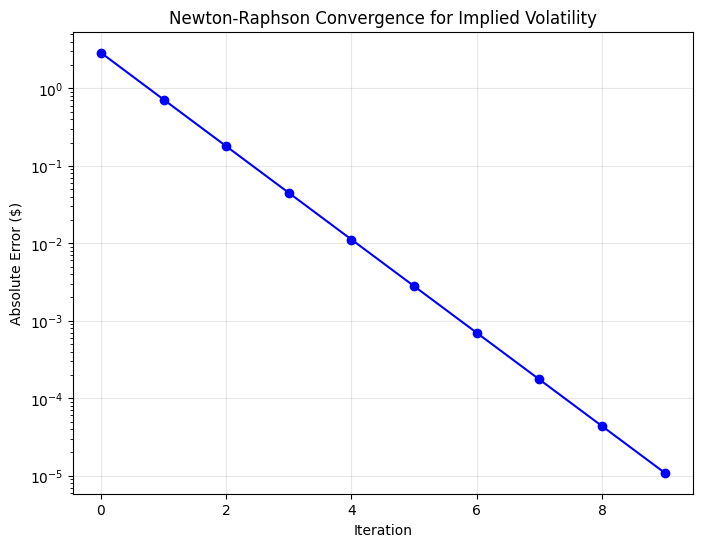

In [21]:
# Let's visualize how the Newton-Raphson method converges to the implied volatility
import numpy as np
import matplotlib.pyplot as plt

def plot_implied_vol_convergence(C, S, K, r, T, sigma_init=0.2):
    """Plot the convergence steps of Newton-Raphson method for implied volatility"""
    def objective(sigma):
        return (black_scholes_call(S, K, r, sigma, T) - C)**2
    
    def derivative(sigma):
        h = 1e-7
        return (objective(sigma + h) - objective(sigma)) / h
    
    # Track convergence steps
    sigmas = []
    errors = []
    sigma = sigma_init
    
    for i in range(10):  # Max 10 iterations
        sigmas.append(sigma)
        error = abs(objective(sigma))
        errors.append(error)
        
        if error < 1e-10:
            break
            
        # Newton-Raphson update
        sigma = sigma - objective(sigma)/derivative(sigma)
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.semilogy(range(len(errors)), errors, 'bo-')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Iteration')
    plt.ylabel('Absolute Error ($)')
    plt.title('Newton-Raphson Convergence for Implied Volatility')
    
    plt.show()

# Plot the convergence for our example
plot_implied_vol_convergence(C=12.15, S=100, K=100, r=0.05, T=1)


In [23]:
# We observe from the market:
S = 100  # Current stock price
K = 100  # Strike price
r = 0.05  # Risk-free interest rate
T = 1     # Time to expiration (in years)
C = 10.15  # Market price of call option

# Calculate implied volatility for our example
implied_vol = implied_volatility(C, S, K, r, T)
print(f"The implied volatility is: {implied_vol:.1%}")

# Verify the result by calculating option price with implied vol
price_check = black_scholes_call(S, K, r, implied_vol, T)
print(f"Original market price: ${C:.2f}")
print(f"Price using implied vol: ${price_check:.2f}")

The implied volatility is: 19.2%
Original market price: $10.15
Price using implied vol: $10.15


---

#### Remarks:

For consistency, *implied volatilities* typically refers to *Black-Scholes Implied Volatilities* that is as the inverse to the Black-Schole pricing function.  Should the context make this ambiguous it will likely define the implied volatility in the context of an alternate model or be referring to this model implied volatility!

Implied volatility uses the current market price(s) to inform the volatility parameter of the Black-Scholes model giving us insight into the level of volatility (a measure of uncertainty) that traders are using in pricing these option contracts!

#### Functions and their Inverses:

Mathematically, a function (like Black-Scholes) maps a value from the domain to a unique value in the range.

e.x.

$f(x) =  2x \implies f(2) = 4$, there is no other value $2$ in the domain is mapped to other than $4$

$$\text{We know 2 maps to 4 and vice versa (4 maps to 2)}$$

In other words, it doesn't matter if we are given a value in the domain or the range when we have a function and its inverse. 

We can go freely back and forth as long as the function and its inverse are well defined!

This is why Black-Scholes Volatility and Black-Scholes Prices are used interchangably for fixed contract/market parameters! 

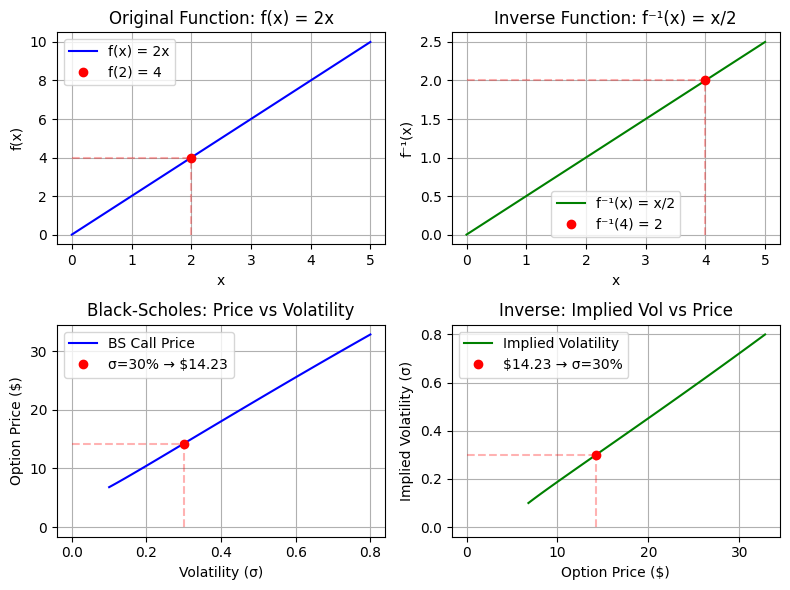

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with four subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

# Plot f(x) = 2x
x = np.linspace(0, 5, 100)
y = 2*x

ax1.plot(x, y, 'b-', label='f(x) = 2x')
ax1.plot([2], [4], 'ro', label='f(2) = 4')
ax1.plot([2, 2], [0, 4], 'r--', alpha=0.3)
ax1.plot([0, 2], [4, 4], 'r--', alpha=0.3)
ax1.set_title('Original Function: f(x) = 2x')
ax1.grid(True)
ax1.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')

# Plot inverse function f⁻¹(x) = x/2
ax2.plot(x, x/2, 'g-', label='f⁻¹(x) = x/2')
ax2.plot([4], [2], 'ro', label='f⁻¹(4) = 2')
ax2.plot([4, 4], [0, 2], 'r--', alpha=0.3)
ax2.plot([0, 4], [2, 2], 'r--', alpha=0.3)
ax2.set_title('Inverse Function: f⁻¹(x) = x/2')
ax2.grid(True)
ax2.legend()
ax2.set_xlabel('x')
ax2.set_ylabel('f⁻¹(x)')

# Plot Black-Scholes call price vs volatility
vol = np.linspace(0.1, 0.8, 100)
S = 100
K = 100
r = 0.05
T = 1
price_at_30 = black_scholes_call(S, K, r, 0.3, T)
prices = [black_scholes_call(S, K, r, v, T) for v in vol]

ax3.plot(vol, prices, 'b-', label='BS Call Price')
ax3.plot([0.3], [price_at_30], 'ro', label=f'σ=30% → ${price_at_30:.2f}')
ax3.plot([0.3, 0.3], [0, price_at_30], 'r--', alpha=0.3)
ax3.plot([0, 0.3], [price_at_30, price_at_30], 'r--', alpha=0.3)
ax3.set_title('Black-Scholes: Price vs Volatility')
ax3.grid(True)
ax3.legend()
ax3.set_xlabel('Volatility (σ)')
ax3.set_ylabel('Option Price ($)')

# Plot implied volatility vs option price by flipping axes
ax4.plot(prices, vol, 'g-', label='Implied Volatility')
ax4.plot([price_at_30], [0.3], 'ro', label=f'${price_at_30:.2f} → σ=30%')
ax4.plot([price_at_30, price_at_30], [0, 0.3], 'r--', alpha=0.3)
ax4.plot([0, price_at_30], [0.3, 0.3], 'r--', alpha=0.3)
ax4.set_title('Inverse: Implied Vol vs Price')
ax4.grid(True)
ax4.legend()
ax4.set_xlabel('Option Price ($)')
ax4.set_ylabel('Implied Volatility (σ)')

plt.tight_layout()
plt.show()


---

### The Implied Volatility Surface

Implied Volatility is simply the volatility required to produce the equilibrium option price under the Black-Scholes framework where the market and contract dictate the rest of the parameters.  With this we can visualize an important concept: **The Implied Volatility Surface**. 

In practice, the implied volatility surface is constructed using

- OTM Puts
- ATM Call/Put which should exhibit the same Implied Volatility by Put/Call Parity
- OTM Calls

at different moneynesses/strikes and times of maturity.  We get to pick the grid!

The following is an example of what an equity volatility surface might look like.

- The downside is priced more expensive than the upside (*fear is on the downside*)

- Something like options on commodities may exhibit the same behavior but in the opposite direction (*fear is on the upside*)

In [9]:
import numpy as np
import plotly.graph_objects as go

# Data for the volatility surface
strikes = [90, 95, 100, 105, 110]
maturities = [1/12, 3/12, 6/12, 1, 2]  # in years
maturity_labels = ['1 Month', '3 Months', '6 Months', '1 Year', '2 Years']

# Volatility values (in %)
vols = np.array([
    [28.0, 24.5, 22.0, 20.5, 19.5],  # 1 month
    [27.5, 24.0, 21.8, 20.3, 19.3],  # 3 months
    [27.0, 23.5, 21.5, 20.0, 19.0],  # 6 months
    [26.5, 23.0, 21.2, 19.8, 18.8],  # 1 year
    [26.0, 22.5, 21.0, 19.5, 18.5]   # 2 years
])

# Create meshgrid for 3D surface
X, Y = np.meshgrid(strikes, maturities)

# Create the 3D surface plot
fig = go.Figure(data=[go.Surface(
    x=X,
    y=Y,
    z=vols,
    colorscale='viridis'
)])

# Update layout
fig.update_layout(
    title='Implied Volatility Surface',
    scene=dict(
        xaxis_title='Strike Price',
        yaxis_title='Time to Maturity (Years)',
        zaxis_title='Implied Volatility (%)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.2)
        )
    ),
    width=800,
    height=600,
    template='plotly_dark',
    paper_bgcolor='rgb(30,30,30)',
    plot_bgcolor='rgb(30,30,30)'
)

# Show the plot
fig.show()


In [10]:
# Create subplots
fig = go.Figure()
fig2 = go.Figure()

# Plot volatility skew for each maturity
for i, (maturity, label) in enumerate(zip(maturities, maturity_labels)):
    fig.add_trace(
        go.Scatter(
            x=strikes,
            y=vols[i],
            name=label,
            mode='lines+markers'
        )
    )

# Plot term structure for each strike
for i, strike in enumerate(strikes):
    fig2.add_trace(
        go.Scatter(
            x=maturities,
            y=vols[:,i],
            name=f'Strike {strike}',
            mode='lines+markers'
        )
    )

# Update layouts
fig.update_layout(
    title='Volatility Skew Across Maturities',
    xaxis_title='Strike Price',
    yaxis_title='Implied Volatility (%)',
    width=500,
    height=400,
    showlegend=True
)

fig2.update_layout(
    title='Volatility Term Structure by Strike', 
    xaxis_title='Time to Maturity (Years)',
    yaxis_title='Implied Volatility (%)',
    width=500,
    height=400,
    showlegend=True
)

# Display plots side by side using subplot
from plotly.subplots import make_subplots
combined_fig = make_subplots(rows=1, cols=2, subplot_titles=("Volatility Skew", "Term Structure of Volatility"))

# Add traces from both figures
for trace in fig.data:
    combined_fig.add_trace(trace, row=1, col=1)
for trace in fig2.data:
    combined_fig.add_trace(trace, row=1, col=2)

# Update layout of combined figure
combined_fig.update_layout(
    width=1000,
    height=400,
    template='plotly_dark',
    paper_bgcolor='rgb(30,30,30)',
    plot_bgcolor='rgb(30,30,30)',
    showlegend=True
)

# Show combined plot
combined_fig.show()


### The Problem (Inconsistent Volatilites, Arbitrage)

The problem:

$BS: (S, K, r, \sigma, T) \mapsto C$

Even though implied volatility for market/contract parameters vary, $\sigma$ is constant!

Think of it this way: *which volatility* do we pick from the surface if they are different for each market/contract combination?

To price options on our desk we need to be consistent with *all* options otherwise we will be subject to arbitrage!

---

### Example: Mispriced *Butterfly Spread* (Volatility Arbitrage)

Though not a pure butterfly spread, 

Imagine we're market making with a constant vol Black-Scholes model (σ = 22.5%)
 for a stock trading at $100. We quote two-way markets for:

 Call A (90 strike):
 - Our price (using 22.5% IV): $12.50
 - Market consensus (25% IV): $13.20

 Call B (110 strike): 
 - Our price (using 22.5% IV): $4.20
 - Market consensus (20% IV): $3.80

 A savvy trader could:
 1. Hit our bid on Call A (we buy too cheap)
 2. Lift our offer on Call B (we sell too expensive)
 3. Delta hedge

 Going long/short ensures a vega-neutral position consistent with out flawed volatility assumption,
 As time passes and volatility realizes according to the market's skew,
 we'll consistently lose money on both legs of this trade.
 The trader profits from our model's flawed constant vol assumption.

 Here the counterparty's arbitrage is in the expected value (statistical) sense.

 For a game that illustrates this concept see: https://practicemarketmaking.com

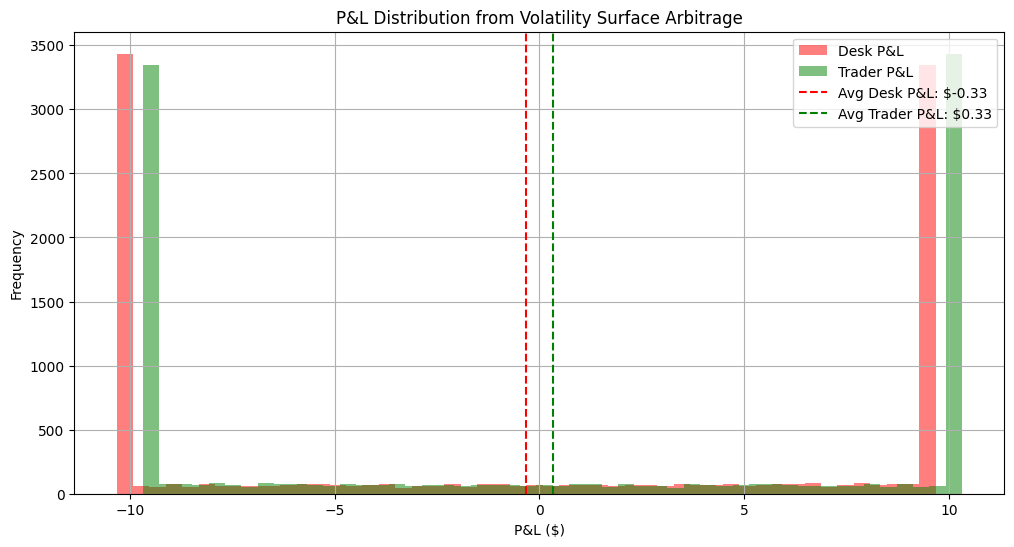

Probability of Desk Loss: 50.5%
Probability of Counterparty Loss: 49.5%
Our Desk EV: $-0.33
Counterparty Desk EV: $0.33


In [11]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Parameters from the example
S0 = 100  # Current stock price
K1, K2 = 90, 110  # Strike prices
r = 0.02  # Risk-free rate
T = 1.0  # Time to maturity
n_paths = 10000
n_steps = 252  # Daily steps for a year

# Market vs our volatilities
sigma_market_K1 = 0.25  # 25% IV for K=90
sigma_market_K2 = 0.20  # 20% IV for K=110
sigma_our = 0.225  # Our constant 22.5% vol

# Black-Scholes call price function
def bs_call(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# Calculate initial prices
our_price_K1 = bs_call(S0, K1, r, sigma_our, T)
market_price_K1 = bs_call(S0, K1, r, sigma_market_K1, T)
our_price_K2 = bs_call(S0, K2, r, sigma_our, T)
market_price_K2 = bs_call(S0, K2, r, sigma_market_K2, T)

# Generate stock price paths using true market volatility structure
dt = T/n_steps
t = np.linspace(0, T, n_steps+1)
W = np.random.standard_normal((n_paths, n_steps+1))
W[:, 0] = 0

# Use average volatility for demonstration
sigma_realized = (sigma_market_K1 + sigma_market_K2)/2
S = np.zeros((n_paths, n_steps+1))
S[:, 0] = S0

for t in range(1, n_steps+1):
    S[:, t] = S[:, t-1] * np.exp((r - 0.5*sigma_realized**2)*dt + 
                                sigma_realized*np.sqrt(dt)*W[:, t])

# Calculate P&L paths
desk_pnl = np.zeros(n_paths)
trader_pnl = np.zeros(n_paths)

for i in range(n_paths):
    # Desk sells K1 call too cheap and buys K2 call too expensive
    desk_pnl[i] = -(max(S[i, -1] - K1, 0) - our_price_K1)  # Loss on K1
    desk_pnl[i] += (max(S[i, -1] - K2, 0) - our_price_K2)  # Loss on K2
    
    # Trader has opposite position
    trader_pnl[i] = -desk_pnl[i]

# Plot results
plt.figure(figsize=(12, 6))
plt.hist(desk_pnl, bins=50, alpha=0.5, label='Desk P&L', color='red')
plt.hist(trader_pnl, bins=50, alpha=0.5, label='Trader P&L', color='green')
plt.axvline(x=np.mean(desk_pnl), color='red', linestyle='--', 
            label=f'Avg Desk P&L: ${np.mean(desk_pnl):.2f}')
plt.axvline(x=np.mean(trader_pnl), color='green', linestyle='--',
            label=f'Avg Trader P&L: ${np.mean(trader_pnl):.2f}')
plt.title('P&L Distribution from Volatility Surface Arbitrage')
plt.xlabel('P&L ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

print(f"Probability of Desk Loss: {np.mean(desk_pnl < 0):.1%}")
print(f"Probability of Counterparty Loss: {np.mean(trader_pnl < 0):.1%}")
print(f"Our Desk EV: ${np.mean(desk_pnl):.2f}")
print(f"Counterparty Desk EV: ${np.mean(trader_pnl):.2f}")


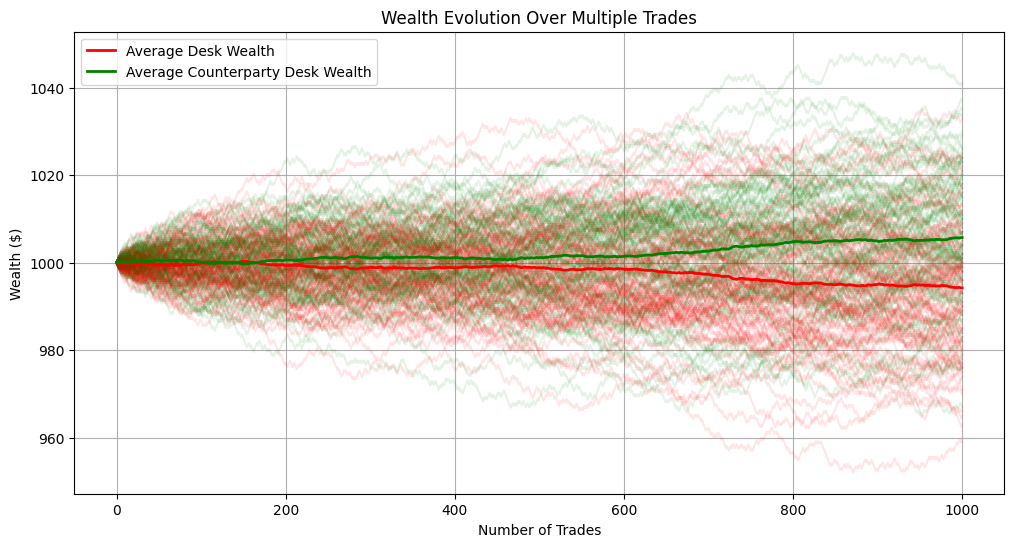

Average Final Desk Wealth: $994.25
Average Final Counterparty Desk Wealth: $1005.75


In [12]:
# Simulate wealth paths over many trades
n_trades = 1000
n_paths = 100
initial_wealth = 1000

# Set parameters from statistics
p_desk_loss = 0.504
desk_ev = -0.25
p_trader_loss = 0.496 
trader_ev = 0.25

# Create arrays to store wealth paths
desk_wealth = np.zeros((n_paths, n_trades+1))
trader_wealth = np.zeros((n_paths, n_trades+1))
desk_wealth[:, 0] = initial_wealth
trader_wealth[:, 0] = initial_wealth

# Simulate paths
for path in range(n_paths):
    for trade in range(n_trades):
        # Generate random outcomes based on probabilities
        desk_outcome = np.random.choice([-1, 1], p=[p_desk_loss, 1-p_desk_loss])
        # Scale outcome to match EV
        if desk_outcome == 1:
            desk_gain = abs(desk_ev/p_desk_loss)
        else:
            desk_gain = -abs(desk_ev/(1-p_desk_loss))
            
        desk_wealth[path, trade+1] = desk_wealth[path, trade] + desk_gain
        trader_wealth[path, trade+1] = trader_wealth[path, trade] - desk_gain

# Plot results
plt.figure(figsize=(12, 6))
trade_nums = np.arange(n_trades+1)

# Plot all paths with low opacity
for path in range(n_paths):
    plt.plot(trade_nums, desk_wealth[path, :], 'r-', alpha=0.1)
    plt.plot(trade_nums, trader_wealth[path, :], 'g-', alpha=0.1)

# Plot means with high opacity
plt.plot(trade_nums, np.mean(desk_wealth, axis=0), 'r-', 
         label='Average Desk Wealth', linewidth=2)
plt.plot(trade_nums, np.mean(trader_wealth, axis=0), 'g-', 
         label='Average Counterparty Desk Wealth', linewidth=2)

plt.title('Wealth Evolution Over Multiple Trades')
plt.xlabel('Number of Trades')
plt.ylabel('Wealth ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print final wealth statistics
print(f"Average Final Desk Wealth: ${np.mean(desk_wealth[:, -1]):.2f}")
print(f"Average Final Counterparty Desk Wealth: ${np.mean(trader_wealth[:, -1]):.2f}")


Thus, we can't use a Black-Scholes model to provide quotes - it is not consistent for even vanilla options under the model's own framework.

If we aren't willing to price vanillas with it, how on earth are we going to price something more illiquid or some OTC exotic?

### The Solution(s)

Fortunately, many very smart people have come up with solutions to this problem offering alternative models for fitting a model parameter set to a volatility surface ensuring consistent prices!

Each has benefits and drawbacks - some ensuring the arbitrage free nature of prices, some capturing richer market heuristics and stylized facts, and others trading these for efficiency.

**Alternative Models**
- Local Volatility (for example, Dupire/Derman)
- Stochastic Volatility (for example, Heston/SABR)
- Jump Diffusion (for example, Merton)
- Rough Models (for example, Gatheral's Rough Bergomi)
- Neural Network Models (for example, Horvath's Deep Learning methodology for approximating pricing functionals)

---

### Example: Heston Model

 The Heston Model (1993) is defined by the following SDEs:
 
 **Stock Price Process:**
  $dS(t) = \mu S(t)dt + \sqrt{v(t)}S(t)dW_1(t)$   # Stock price process

**Volatility Process (Ornstein-Uhlenbeck):**
  $dv(t) = \kappa(\theta - v(t))dt + \sigma\sqrt{v(t)}dW_2(t)$  

 Where:
 - S(t) is the stock price
 - v(t) is the variance (volatility squared)
 - μ is the drift
 - κ is the mean reversion speed
 - θ is the long-run variance
 - σ is the volatility of variance

 The Brownian motions W₁ and W₂ are correlated with:
 corr(dW₁, dW₂) = ρdt

Check out https://gaussiancookbook.com and my note on SSRN to see recipes for simulating stochastic processes with a desired covariance structure!

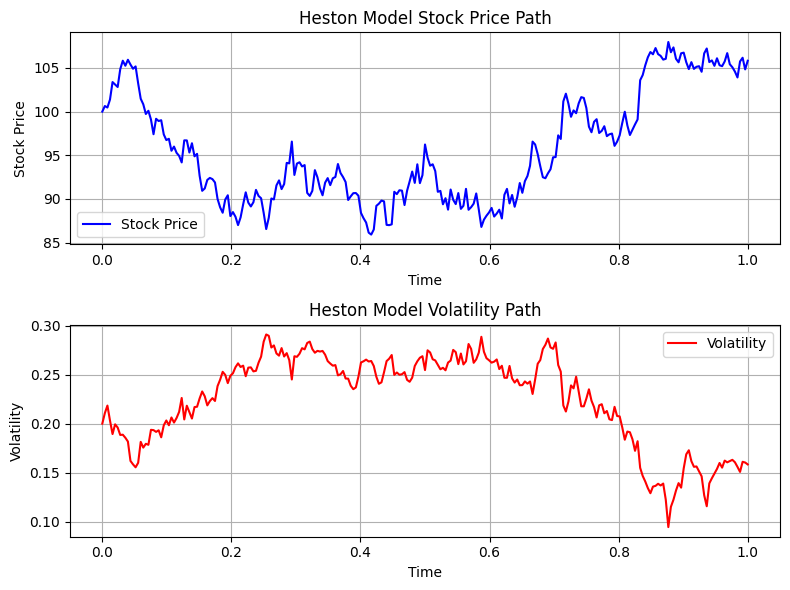

Strike 90: Put Price = 0.8281, Implied Vol = 0.2271
Strike 110: Call Price = 0.8448, Implied Vol = 0.1754

Heston Pricing Functional Market/Contract Parameters:
Initial Stock Price (S0): 100
Risk-free Rate: 5%
Time to Maturity: 0.25 years
Initial Variance (v0): 0.04
Mean Reversion Speed (kappa): 2.0
Long-run Variance (theta): 0.04
Volatility of Variance (sigma): 0.3
Correlation (rho): -0.7


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Heston model parameters
v0 = 0.04      # initial variance
kappa = 2.0    # mean reversion speed
theta = 0.04   # long-run variance
sigma = 0.3    # volatility of variance
rho = -0.7     # correlation
S0 = 100       # initial stock price
T = 1.0        # time horizon
N = 252        # number of time steps
dt = T/N       # time step size

# Generate correlated Brownian motions
Z1 = np.random.standard_normal(N)
Z2 = rho * Z1 + np.sqrt(1-rho**2) * np.random.standard_normal(N)

# Initialize arrays
S = np.zeros(N+1)
v = np.zeros(N+1)
t = np.linspace(0, T, N+1)

# Set initial values
S[0] = S0
v[0] = v0

# Simulate paths
for i in range(N):
    v[i+1] = v[i] + kappa*(theta - v[i])*dt + sigma*np.sqrt(v[i]*dt)*Z2[i]
    v[i+1] = max(v[i+1], 0)  # ensure variance stays positive
    S[i+1] = S[i] * np.exp((0.05 - 0.5*v[i])*dt + np.sqrt(v[i]*dt)*Z1[i])

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Stock price path
ax1.plot(t, S, 'b-', label='Stock Price')
ax1.set_title('Heston Model Stock Price Path')
ax1.set_xlabel('Time')
ax1.set_ylabel('Stock Price')
ax1.grid(True)
ax1.legend()

# Volatility path
ax2.plot(t, np.sqrt(v), 'r-', label='Volatility')
ax2.set_title('Heston Model Volatility Path')
ax2.set_xlabel('Time')
ax2.set_ylabel('Volatility')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()
# Calculate option prices and implied vols for two strikes
K1, K2 = 90, 110  # strikes
T_opt = 0.25      # 3-month option

# Calculate terminal stock prices for many paths
n_paths = 10000
Z1_many = np.random.standard_normal((n_paths, N))
Z2_many = rho * Z1_many + np.sqrt(1-rho**2) * np.random.standard_normal((n_paths, N))

S_paths = np.zeros((n_paths, N+1))
v_paths = np.zeros((n_paths, N+1))
S_paths[:,0] = S0
v_paths[:,0] = v0

# Simulate many paths
for i in range(N):
    v_paths[:,i+1] = v_paths[:,i] + kappa*(theta - v_paths[:,i])*dt + sigma*np.sqrt(v_paths[:,i]*dt)*Z2_many[:,i]
    v_paths[:,i+1] = np.maximum(v_paths[:,i+1], 0)
    S_paths[:,i+1] = S_paths[:,i] * np.exp((0.05 - 0.5*v_paths[:,i])*dt + np.sqrt(v_paths[:,i]*dt)*Z1_many[:,i])

# Calculate option prices from MC simulation
idx_T = int(T_opt/dt)
put_price_K1 = np.mean(np.maximum(K1 - S_paths[:,idx_T], 0)) * np.exp(-0.05*T_opt)
call_price_K2 = np.mean(np.maximum(S_paths[:,idx_T] - K2, 0)) * np.exp(-0.05*T_opt)

# Calculate implied volatilities using Newton's method
from scipy.optimize import newton

def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bs_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def implied_vol_put(P, S, K, T, r):
    f = lambda sigma: bs_put(S, K, T, r, sigma) - P
    return newton(f, x0=0.2)

def implied_vol_call(C, S, K, T, r):
    f = lambda sigma: bs_call(S, K, T, r, sigma) - C
    return newton(f, x0=0.2)

impl_vol_K1 = implied_vol_put(put_price_K1, S0, K1, T_opt, 0.05)
impl_vol_K2 = implied_vol_call(call_price_K2, S0, K2, T_opt, 0.05)

print(f"Strike {K1}: Put Price = {put_price_K1:.4f}, Implied Vol = {impl_vol_K1:.4f}")
print(f"Strike {K2}: Call Price = {call_price_K2:.4f}, Implied Vol = {impl_vol_K2:.4f}")

print("\nHeston Pricing Functional Market/Contract Parameters:")
print(f"Initial Stock Price (S0): {S0}")
print(f"Risk-free Rate: 5%")
print(f"Time to Maturity: {T_opt} years")
print(f"Initial Variance (v0): {v0}")
print(f"Mean Reversion Speed (kappa): {kappa}")
print(f"Long-run Variance (theta): {theta}")
print(f"Volatility of Variance (sigma): {sigma}")
print(f"Correlation (rho): {rho}")


---

### Applications and Closing Thoughts

The Implied Volatility surface is arguably the most important concept in the pricing of options.

**So what makes for a good model? (local vol, stochastic vol, etc.)**
- Consistent pricing
- Arbitrage free *gaurentees* (opposed to something like a neural network functional approximation)
- Efficient for online pricing - calibration and speed and accuracy matters for providing two-ways!
- Says as little as possible about the *true* market distribution


In this video we've covered
- Black-Scholes Model
- Implied Volatility Surface
- Calibration Problem with Black-Scholes
- Solutions to this Black-Scholes Calibration Problem

In a later video we will cover the pricing of exotic options by:
- Calibrating Models to a Volatility Surface
- Extrapolating Exotic Option Prices
- Decomposing the Quote
- (Perhaps) Hedging Schemes